<AxesSubplot:>

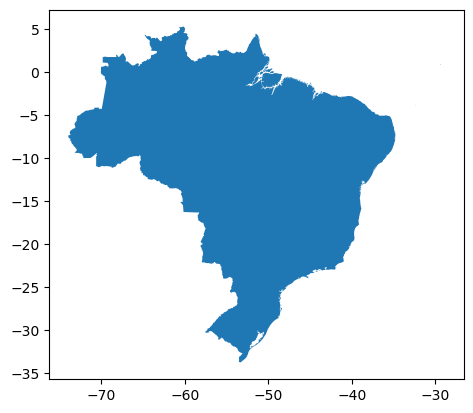

In [1]:
import geopandas as gpd
import pandas as pd

# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp
df = gpd.read_file('../resources/data/ne_10m_admin_0_countries.shp')

brazil = df.loc[df['ADMIN'] == 'Brazil']
brazil.plot()

In [2]:
import rasterio

topography_file = rasterio.open('../resources/data/ETOPO1_Bed_g_geotiff.tif')

In [3]:
from rasterio import mask as msk 
from shapely.geometry import mapping

clipped_array, clipped_transform = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=0)

In [4]:
import numpy as np

print(np.amin(clipped_array))
print(np.amax(clipped_array))

-2802
2608


In [5]:
clipped_array, clipped_transform = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=-28)

In [6]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm
import matplotlib.pyplot as plt

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 2002))
background_colour = np.array([0.0, 0.0, 0.0, 0.0])
colors_land[:1, :] = background_colour
newcmp_topo = ListedColormap(colors_land)

bounds = np.arange(-28, 1975, 1)
norm_topo = BoundaryNorm(bounds, newcmp_topo.N)

In [7]:
rows, cols = clipped_array[0].shape
col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

# Calculate the real-world coordinates
xs, ys = rasterio.transform.xy(clipped_transform, row_indices.flatten(), col_indices.flatten())

# Create a DataFrame
df = pd.DataFrame({
    'X': xs,
    'Y': ys,
    'Value': clipped_array[0].flatten()
})

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))

print(gdf)

                 X          Y  Value                     geometry
0       -74.016667   5.266667    -28    POINT (-74.01667 5.26667)
1       -74.000000   5.266667    -28    POINT (-74.00000 5.26667)
2       -73.983333   5.266667    -28    POINT (-73.98333 5.26667)
3       -73.966667   5.266667    -28    POINT (-73.96667 5.26667)
4       -73.950000   5.266667    -28    POINT (-73.95000 5.26667)
...            ...        ...    ...                          ...
6344473 -28.950000 -33.750000    -28  POINT (-28.95000 -33.75000)
6344474 -28.933333 -33.750000    -28  POINT (-28.93333 -33.75000)
6344475 -28.916667 -33.750000    -28  POINT (-28.91667 -33.75000)
6344476 -28.900000 -33.750000    -28  POINT (-28.90000 -33.75000)
6344477 -28.883333 -33.750000    -28  POINT (-28.88333 -33.75000)

[6344478 rows x 4 columns]


<AxesSubplot:>

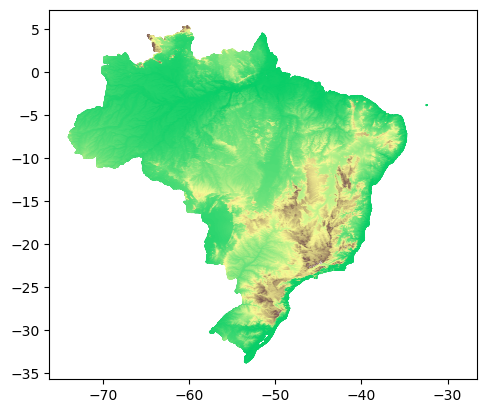

In [8]:
gdf.plot(column='Value', s=2, cmap=newcmp_topo, norm=norm_topo, edgecolors='none')

In [9]:
import numpy as np
from osgeo import gdal, ogr
from osgeo import osr
from rasterio.transform import from_origin

gdal_transform = (clipped_transform.c, clipped_transform.a, clipped_transform.b,
                  clipped_transform.f, clipped_transform.d, clipped_transform.e)

# Create an in-memory raster
mem_drv_raster = gdal.GetDriverByName('MEM')
mem_raster = mem_drv_raster.Create('', clipped_array[0].shape[1], clipped_array[0].shape[0], 1, gdal.GDT_Int32)

# Set the geotransform
mem_raster.SetGeoTransform(gdal_transform)

# Write the data
mem_raster.GetRasterBand(1).WriteArray(clipped_array[0])

# Create an in-memory vector layer
mem_drv_vector = ogr.GetDriverByName('Memory')
mem_vector = mem_drv_vector.CreateDataSource('out')
mem_layer = mem_vector.CreateLayer('polygonized_raster', geom_type=ogr.wkbPolygon)

# Add a new field to store raster values
new_field = ogr.FieldDefn('DN', ogr.OFTInteger)
mem_layer.CreateField(new_field)

# Polygonize the raster to the in-memory vector layer
gdal.Polygonize(mem_raster.GetRasterBand(1), None, mem_layer, 0, [], callback=None)


0

In [10]:
from shapely.geometry import Polygon

geoms = []
vals = []

# Access the polygons
for feature in mem_layer:
    geom = feature.GetGeometryRef()
    
    # Extract the coordinates from the geometry
    ring = geom.GetGeometryRef(0)
    coordinates = []
    for i in range(ring.GetPointCount()):
        x, y = ring.GetX(i), ring.GetY(i)
        coordinates.append((x, y))
        
    geoms.append(Polygon(coordinates))
    vals.append(feature.GetField('DN'))

gdf = gpd.GeoDataFrame(pd.DataFrame({'vals': vals}), crs='EPSG:4326', geometry=geoms)

print(gdf)

         vals                                           geometry
0        1099  POLYGON ((-60.27500 5.25833, -60.27500 5.24167...
1        1263  POLYGON ((-60.25833 5.25833, -60.25833 5.24167...
2        1255  POLYGON ((-60.24167 5.25833, -60.24167 5.24167...
3        1260  POLYGON ((-60.22500 5.25833, -60.22500 5.22500...
4        1300  POLYGON ((-60.20833 5.25833, -60.20833 5.24167...
...       ...                                                ...
2276648     9  POLYGON ((-53.35833 -33.70833, -53.35833 -33.7...
2276649     6  POLYGON ((-53.42500 -33.72500, -53.42500 -33.7...
2276650    13  POLYGON ((-53.39167 -33.72500, -53.39167 -33.7...
2276651     9  POLYGON ((-53.37500 -33.72500, -53.37500 -33.7...
2276652   -28  POLYGON ((-74.02500 5.27500, -74.02500 -33.758...

[2276653 rows x 2 columns]


<AxesSubplot:>

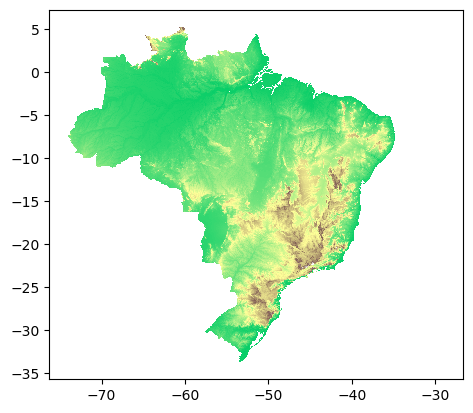

In [11]:
gdf.plot(column='vals', cmap=newcmp_topo, norm=norm_topo)

In [12]:
from osgeo import ogr


# Generate contours directly in memory
mem_ds = ogr.GetDriverByName('Memory').CreateDataSource('out')
contour_lyr = mem_ds.CreateLayer('contour', geom_type=ogr.wkbLineString25D)

# Define fields of id and elev
field_def = ogr.FieldDefn("ID", ogr.OFTInteger)
contour_lyr.CreateField(field_def)
field_def = ogr.FieldDefn("elev", ogr.OFTReal)
contour_lyr.CreateField(field_def)

# Generate contours
gdal.ContourGenerate(mem_raster.GetRasterBand(1), 50, -11, [], 0, 0, contour_lyr, 0, 1)

gdal.Unlink('/vsimem/temp.vrt')
gdal.Unlink('/vsimem/mosaic.tif')

-1

In [13]:
from shapely.geometry import LineString

lines = [LineString(np.array(contour.GetGeometryRef().GetPoints())) for contour in contour_lyr]
elev = [contour.GetField('elev') for contour in contour_lyr]
gdf = gpd.GeoDataFrame(pd.DataFrame({'elev': elev}), crs="EPSG:4326", geometry=lines)
print(gdf)

         elev                                           geometry
0      1389.0  LINESTRING Z (-60.16343 5.21667 1389.00000, -6...
1       989.0  LINESTRING Z (-60.38240 5.20000 989.00000, -60...
2      1039.0  LINESTRING Z (-60.38318 5.20000 1039.00000, -6...
3      1089.0  LINESTRING Z (-60.30015 5.20000 1089.00000, -6...
4      1139.0  LINESTRING Z (-60.30759 5.20000 1139.00000, -6...
...       ...                                                ...
66955  -111.0  LINESTRING Z (-53.46667 -33.45833 -111.00000, ...
66956   -61.0  LINESTRING Z (-53.11667 -33.49031 -61.00000, -...
66957   -11.0  LINESTRING Z (-53.10000 -33.50805 -11.00000, -...
66958   -61.0  LINESTRING Z (-53.48333 -33.52019 -61.00000, -...
66959   -11.0  LINESTRING Z (-53.35766 -33.73333 -11.00000, -...

[66960 rows x 2 columns]


<AxesSubplot:>

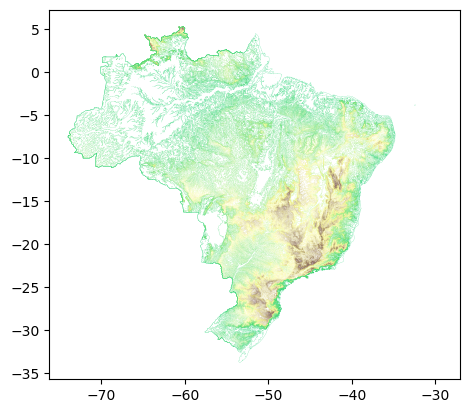

In [14]:
gdf.plot(lw=0.1, column='elev', cmap=newcmp_topo, norm=norm_topo)

C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


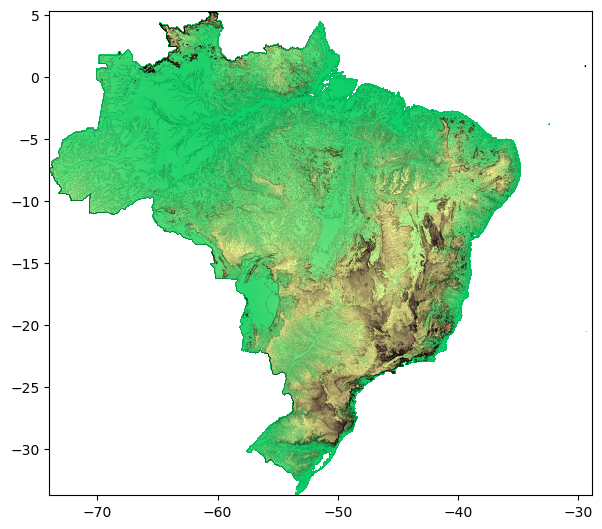

In [15]:
from rasterio.plot import show


fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

show(clipped_array, ax=ax, transform=clipped_transform, cmap=newcmp_topo, norm=norm_topo)
gdf.plot(lw=0.05, ax=ax, column='elev', color='black')

plt.savefig("test.png", dpi=1000, bbox_inches='tight')
plt.show()

In [16]:
samerica_rivers = gpd.read_file("../resources/data/rivers.geojson")

leftSpan = np.amax(samerica_rivers['DIST_UP_KM']) - np.amin(samerica_rivers['DIST_UP_KM'])
rightSpan = 1 - 0.1
valueScaled = (samerica_rivers['DIST_UP_KM'] - np.amin(samerica_rivers['DIST_UP_KM'])) / leftSpan
samerica_rivers['LW_DIST_UP_KM'] = 0.1 + (valueScaled * rightSpan)


C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


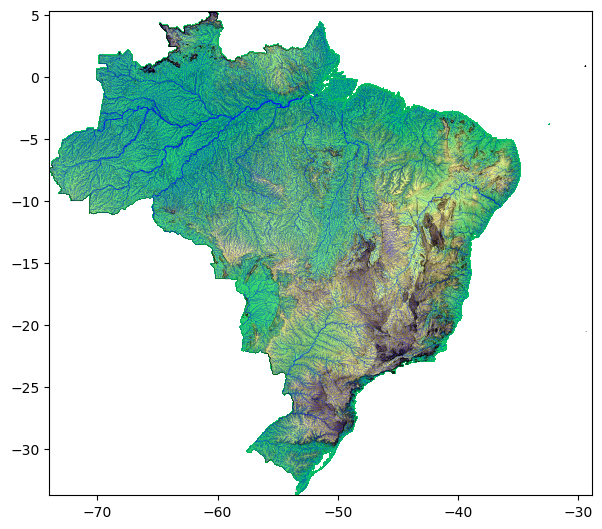

In [17]:
from rasterio.plot import show

fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

show(clipped_array, ax=ax, transform=clipped_transform, cmap=newcmp_topo, norm=norm_topo)
gdf.plot(lw=0.05, ax=ax, column='elev', color='black')
samerica_rivers.plot(ax=ax, edgecolor='face', color='blue', lw=samerica_rivers['LW_DIST_UP_KM'])

plt.show()